# Pump It Up - Data Mining the Water Table  
We take part in the Driven Data competition 'Pump It Up - Data Mining the Water Table' at  
https://www.drivendata.org/competitions/7/pump-it-up-data-mining-the-water-table/page/23/

## Import libraries

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier

import imblearn
from imblearn.over_sampling import RandomOverSampler

## Load dataset and perform initial checks

In [2]:
df_train_values = pd.read_csv('./training_set_values.csv')
df_train_labels = pd.read_csv('./training_set_labels.csv')
df_test_values = pd.read_csv('./test_set_values.csv')

Check that values and labels datasets have same length

In [3]:
print(df_train_values.shape)
print(df_train_labels.shape)

(59400, 40)
(59400, 2)


Check head of values and labels datasets

In [4]:
df_train_values.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,...,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,...,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,...,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,...,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,...,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe


In [5]:
df_train_labels.head()

,id,status_group
0,69572,functional
1,8776,functional
2,34310,functional
3,67743,non functional
4,19728,functional


Check that rows have same order among the two df. If all ids match, we should get 0 below:

In [6]:
np.sum(df_train_values['id']-df_train_labels['id'])

0

Check info (names, types, any missing values):

In [7]:
df_train_labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59400 entries, 0 to 59399
Data columns (total 2 columns):
id              59400 non-null int64
status_group    59400 non-null object
dtypes: int64(1), object(1)
memory usage: 928.2+ KB


We observe no missing values for the labels dataset.

In [8]:
df_train_values.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59400 entries, 0 to 59399
Data columns (total 40 columns):
id                       59400 non-null int64
amount_tsh               59400 non-null float64
date_recorded            59400 non-null object
funder                   55765 non-null object
gps_height               59400 non-null int64
installer                55745 non-null object
longitude                59400 non-null float64
latitude                 59400 non-null float64
wpt_name                 59400 non-null object
num_private              59400 non-null int64
basin                    59400 non-null object
subvillage               59029 non-null object
region                   59400 non-null object
region_code              59400 non-null int64
district_code            59400 non-null int64
lga                      59400 non-null object
ward                     59400 non-null object
population               59400 non-null int64
public_meeting           56066 non-null object
r

We see that some features have missing values. We print out explicitly which features do:

In [9]:
df_train_values.columns[df_train_values.isnull().any()]

Index(['funder', 'installer', 'subvillage', 'public_meeting',
       'scheme_management', 'scheme_name', 'permit'],
      dtype='object')

Finally, print out some basic statistics about numerical features

In [10]:
df_train_values.describe().drop(['id'],axis=1)

,amount_tsh,gps_height,longitude,latitude,num_private,region_code,district_code,population,construction_year
count,59400.000000,59400.000000,59400.000000,5.940000e+04,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000
mean,317.650385,668.297239,34.077427,-5.706033e+00,0.474141,15.297003,5.629747,179.909983,1300.652475
std,2997.574558,693.116350,6.567432,2.946019e+00,12.236230,17.587406,9.633649,471.482176,951.620547
min,0.000000,-90.000000,0.000000,-1.164944e+01,0.000000,1.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,33.090347,-8.540621e+00,0.000000,5.000000,2.000000,0.000000,0.000000
50%,0.000000,369.000000,34.908743,-5.021597e+00,0.000000,12.000000,3.000000,25.000000,1986.000000
75%,20.000000,1319.250000,37.178387,-3.326156e+00,0.000000,17.000000,5.000000,215.000000,2004.000000
max,350000.000000,2770.000000,40.345193,-2.000000e-08,1776.000000,99.000000,80.000000,30500.000000,2013.000000


A few comments:  
- 'amount_tsh' seems to have some problems (most of the values are zero and max is much higher than 75th pencentile)
- 'gps_height' looks ok. Altitudes in Tanzania vary between sea level and Mount Kilimanjaro at 5,895m. Since we are talking about wells, a negative value (meaning a well below sea level) still looks reasonable.
- from this website (https://www.worldatlas.com/af/tz/where-is-tanzania.html) we learn that Tanzania is positioned in the latitude range of [-11.75,-0.99] and longitude range of [29.33,40.45]. This means that the min of 'longitude' cannot be correct as well as the max of 'latitude'. The other values look ok.
- from the competition description it's not clear what 'num_private' corresponds to.
- 'region_code' and 'district_code' look ok for all we know.
- the max of 'population' looks like an outlier given the other percentiles (also a lot of zero values).
- 'construction_year' of 0 cannot obviously be correct (many zero values).

## EDA

Heatmap of the correlations between the numerical features

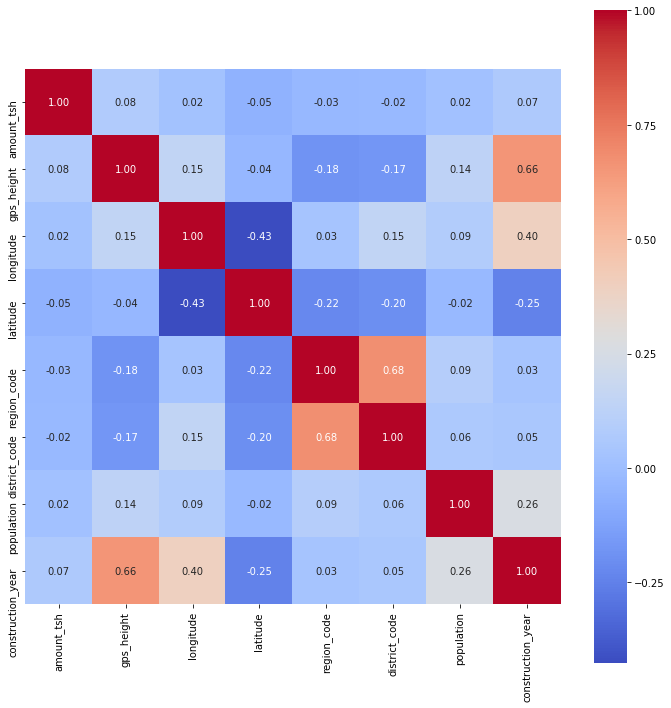

In [11]:
plt.figure(figsize=(12,12))
sns.heatmap(df_train_values.drop(['id','num_private'],axis=1).corr(), square=True, annot=True, fmt='.2f', cmap='coolwarm')
plt.show()

In general we do not observe extremely large positive or negative correlations between features. The feature 'construction_year' seems to be correlated with 'gps_height', indicating that maybe wells located in the mountains were built more recently than wells at lower altitudes (probably easier to build). There also seems to be positive correlation between 'region_code' and 'district_code' which could simply be a consequence of how these codes have been established (we do not have details about them in the competition description). Finally, we observe a mild correlation between 'latitude' and 'longitude' (negative, probably just due to the shape of the country itself, see below) and between 'longitude' and 'construction_year' (positive, indicating that wells were likely built first in the west part of the country and then in the east part).

Scatter plot of latitude and longitude to visualize where the wells are. It's interesting to observe that we reproduce the shape of the country pretty well.

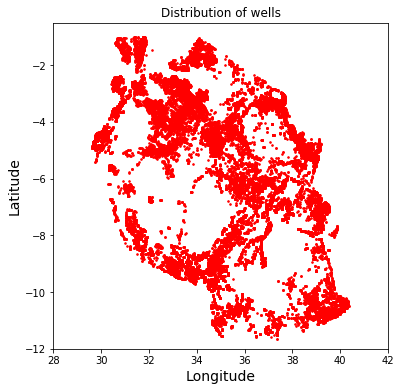

In [12]:
plt.figure(figsize=(6,6))
plt.scatter(df_train_values['longitude'], df_train_values['latitude'], 10, marker='.', c='r')
plt.xlabel('Longitude',size=14)
plt.ylabel('Latitude',size=14)
plt.xlim(28,42)
plt.ylim(-12,-0.5)
plt.title('Distribution of wells')
plt.show()

Check if the train dataset is balanced on the target or not:

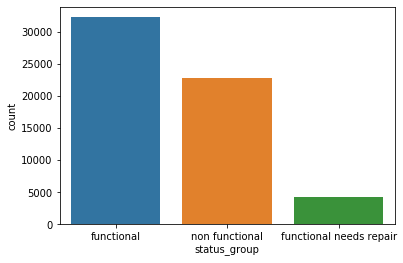

In [13]:
sns.countplot(x='status_group', data=df_train_labels)
plt.show()

In [14]:
df_train_labels['status_group'].value_counts()/len(df_train_labels)

functional                 0.543081
non functional             0.384242
functional needs repair    0.072677
Name: status_group, dtype: float64

We observe that the train set has 54.3% functional wells, 38.4% non-functional wells, and 7.3% functional wells that need repair.

## Data cleaning and pre-processing

### Create train target without one-hot encoding

In [15]:
train_target_nohe = df_train_labels.drop('id',axis=1)

### Create train target with one-hot encoding

In [16]:
train_target_ohe = df_train_labels.copy()
train_target_ohe = pd.get_dummies(train_target_ohe,columns=['status_group'],drop_first=True)
train_target_ohe.drop('id',axis=1, inplace=True)

Check possible target values and what was dropped during one-hot encoding

In [17]:
sorted_target_values = sorted(list(df_train_labels['status_group'].unique()))
print(sorted_target_values)

['functional', 'functional needs repair', 'non functional']


In [18]:
list(train_target_ohe.columns)

['status_group_functional needs repair', 'status_group_non functional']

### Balance dataset on minority classes by random oversampling

In [21]:
#train_target_nohe_num = train_target_nohe.replace({'functional': 0, 'non functional': 1, 'functional needs repair': 2})

#ros = RandomOverSampler()
#X_ros, y_ros = ros.fit_sample(df_train_values.values, np.array(train_target_nohe_num['status_group']))
#df_train_values_ros = pd.DataFrame(X_ros,columns=df_train_values.columns)
#train_target_nohe_ros = pd.DataFrame(y_ros,columns=['status_group'])
#train_target_nohe_ros.replace({0: 'functional', 1:'non functional', 2:'functional needs repair'},inplace=True)

#sns.countplot(x='status_group', data=train_target_nohe_ros)
#plt.show()

### Work on features & feature engineering

In [27]:
#df_train_values_ros

In [172]:
train_len = len(df_train_values)
df_train_test_preprocessed = pd.concat([df_train_values,df_test_values])

We initially drop features with no predictive power ('id', 'num_private', 'recorded_by') and then work on each feature individually.

In [173]:
columns_to_drop = ['id','num_private','recorded_by']

In [174]:
df_train_test_preprocessed.drop(columns_to_drop,axis=1, inplace=True)

#### 'amount_tsh'  
We observe that 70% of the values correspond to 0, which probably indicates a missing value. We therefore drop this feature.

In [175]:
sum(df_train_test_preprocessed['amount_tsh'] == 0.0)/len(df_train_test_preprocessed)

0.700996632996633

In [176]:
df_train_test_preprocessed.drop(['amount_tsh'],axis=1, inplace=True)

#### 'date_recorded'  
The functioning of a well might have seasonal effects (rain season etc) so the date might be useful in the month format (since we're interested in seasonal effects).

In [177]:
df_train_test_preprocessed['date_recorded'] = pd.to_datetime(df_train_test_preprocessed['date_recorded']).dt.month

#### 'funder'  
Values with value_counts below 500 are all renamed 'Other'. Rename duplicates and '0' probably corresponds to NaN. We use mode imputation for NaNs.

In [178]:
df_train_test_preprocessed['funder'].replace({'Ministry Of Water':'Government Of Tanzania',
                                              'Nerthlands':'Netherlands',
                                              'Private':'Private Individual','Kkkt Church':'Kkkt',
                                              'Kkkt_makwale':'Kkkt','Finw':'Fini Water','Fin Water':'Fini Water',
                                              'Unice':'Unicef','Concern':'Concern World Wide',
                                              'Roman':'Rc Church','Rc':'Rc Church','Roman Catholic':'Rc Church',
                                              'Worldvision':'World Vision','W0rld  Bank':'World Bank'},inplace=True)
df_train_test_preprocessed['funder'].replace('0',np.nan,inplace=True)
df_train_test_preprocessed['funder'].fillna(df_train_test_preprocessed['funder'].mode()[0],inplace=True)

In [179]:
funder_freqs = df_train_test_preprocessed['funder'].value_counts()
funder_cond = funder_freqs<500

funder_mask_obs = funder_freqs[funder_cond].index
funder_mask_dict = dict.fromkeys(funder_mask_obs,'Other')

df_train_test_preprocessed['funder'].replace(funder_mask_dict,inplace=True)

#### 'gps_height'  
Median imputation for 0 (=NaN) based on what region the entry is in. If for that region no entry has a non-zero value for 'gps_height', then median imputation based on the whole dataset.

In [180]:
df_train_test_preprocessed['gps_height'].replace(0,np.nan,inplace=True)

gps_height_median = df_train_test_preprocessed['gps_height'].median()
df_gps_height_median_by_region = df_train_test_preprocessed.groupby('region')[['gps_height']].median()

In [181]:
df_train_test_preprocessed['gps_height'] = df_train_test_preprocessed.apply(lambda row: df_gps_height_median_by_region.loc[row['region']][0] if np.isnan(row['gps_height']) else row['gps_height'], axis=1)

In [182]:
df_train_test_preprocessed['gps_height'].fillna(gps_height_median,inplace=True)

#### 'installer'  
Rename duplicates, mode imputation for NaNs, and group less frequent values (value_counts<400) into 'Other'.

In [183]:
df_train_test_preprocessed['installer'].replace({'Central government':'Government',
                                            'District council':'District Council',
                                            'World vision':'World Vision',
                                            'Commu':'Community',
                                            'HESAWA':'Hesawa',
                                            'Gover':'Government','Gove':'Government','Centr':'Government',
                                            'Central govt':'Government','GOVER':'Government'},inplace=True)
df_train_test_preprocessed['installer'].replace('0',np.nan,inplace=True)
df_train_test_preprocessed['installer'].fillna(df_train_test_preprocessed['installer'].mode()[0],inplace=True)

In [184]:
installer_freqs = df_train_test_preprocessed['installer'].value_counts()
installer_cond = installer_freqs<400

installer_mask_obs = installer_freqs[installer_cond].index
installer_mask_dict = dict.fromkeys(installer_mask_obs,'Other')

df_train_test_preprocessed['installer'].replace(installer_mask_dict,inplace=True)

#### 'longitude' and 'latitude'  
We know that Tanzania has latitude [-11.75,-0.99] and longitude [29.33,40.45] so values of [0,0] are clearly wrong. We replace those values with the average latitude and longitude of the district that entry is in (based on 'district_code').

In [185]:
df_train_test_preprocessed.loc[df_train_test_preprocessed['longitude'] < 29.33,'longitude'] = np.nan
df_train_test_preprocessed.loc[df_train_test_preprocessed['latitude'] > -0.99,'latitude'] = np.nan

df_longitude_mean_by_district_code = df_train_test_preprocessed.groupby('district_code')[['longitude']].mean()
df_latitude_mean_by_district_code = df_train_test_preprocessed.groupby('district_code')[['latitude']].mean()

In [188]:
df_train_test_preprocessed['longitude'] = df_train_test_preprocessed.apply(lambda row: df_longitude_mean_by_district_code.loc[row['district_code']][0] if np.isnan(row['longitude']) else row['longitude'], axis=1)

df_train_test_preprocessed['latitude'] = df_train_test_preprocessed.apply(lambda row: df_latitude_mean_by_district_code.loc[row['district_code']][0] if np.isnan(row['latitude']) else row['latitude'], axis=1)

#### 'basin', 'region', 'region_code', 'district_code'  
We keep 'basin', 'region', and 'district_code' untouched. We drop 'region_code' since it's essentially a copy of 'region'.

In [189]:
df_train_test_preprocessed.drop(['region_code'],axis=1, inplace=True)

#### 'lga'  
We split 'lga' into 'Urban', 'Rural', or 'Other'.

In [190]:
df_train_test_preprocessed.loc[df_train_test_preprocessed['lga'].str.contains('Urban',case=False),'lga'] = 'Urban'
df_train_test_preprocessed.loc[df_train_test_preprocessed['lga'].str.contains('Rural',case=False),'lga'] = 'Rural'
df_train_test_preprocessed.loc[~df_train_test_preprocessed['lga'].str.contains('Rural',case=False) & 
                               ~df_train_test_preprocessed['lga'].str.contains('Urban',case=False),'lga'] = 'Other'

#### 'ward', 'subvillage', 'wpt_name'
We drop these features since they have too many different values to have any predicting power.

In [191]:
df_train_test_preprocessed.drop(['ward','subvillage','wpt_name'],axis=1, inplace=True)

#### 'population'  
Population values of 0 and 1 are suspicious (might indicate missing values) and they make up almost 48% of the values in the train set so we decide to drop this feature.

In [192]:
df_train_test_preprocessed.drop(['population'],axis=1, inplace=True)

#### 'public_meeting' and 'permit'
Mode imputation for missing values

In [193]:
pmp_fill_missing_values = {'public_meeting': df_train_test_preprocessed['public_meeting'].mode()[0],
                           'permit': df_train_test_preprocessed['permit'].mode()[0]}

df_train_test_preprocessed.fillna(pmp_fill_missing_values,inplace=True)

#### 'scheme_name', 'scheme_management'
Drop 'scheme_name' because of too many different values. Rename duplicates and mode imputation for 'scheme_management'.

In [194]:
df_train_test_preprocessed['scheme_management'].replace({'Water authority':'Water Board','None':np.nan},inplace=True)
df_train_test_preprocessed['scheme_management'].fillna(df_train_test_preprocessed['scheme_management'].mode()[0],inplace=True)

df_train_test_preprocessed.drop(['scheme_name'],axis=1, inplace=True)

#### 'construction_year'  
Median imputation for 0 (=NaN) based on what region the entry is in. If for that region no entry has a non-zero value for 'gps_height', then median imputation based on the whole dataset.

In [195]:
df_train_test_preprocessed['construction_year'].replace(0,np.nan,inplace=True)

construction_year_median = df_train_test_preprocessed['construction_year'].median()
df_construction_year_median_by_region = df_train_test_preprocessed.groupby('region')[['construction_year']].median()

In [196]:
df_train_test_preprocessed['construction_year'] = df_train_test_preprocessed.apply(lambda row: df_construction_year_median_by_region.loc[row['region']][0] if np.isnan(row['construction_year']) else row['construction_year'], axis=1)

In [197]:
df_train_test_preprocessed['construction_year'].fillna(construction_year_median,inplace=True)

#### 'extraction_type', 'extraction_type_group', 'extraction_type_class'

In [198]:
df_train_test_preprocessed['extraction_type'].replace({'swn 80':'swn','other - swn 81':'swn',
                                                  'india mark ii':'india mark','india mark iii':'india mark'},inplace=True)

In [199]:
df_train_test_preprocessed.drop(['extraction_type_group'],axis=1, inplace=True)

#### 'management', 'management_group'

In [200]:
df_train_test_preprocessed['management_group'].replace('unknown',df_train_test_preprocessed['management_group'].mode()[0],inplace=True)

df_train_test_preprocessed['management'].replace({'water authority':'water board','unknown':df_train_test_preprocessed['management'].mode()[0]},inplace=True)

#### 'payment', 'payment_type'

In [201]:
df_train_test_preprocessed['payment'].replace('unknown',df_train_test_preprocessed['payment'].mode()[0],inplace=True)

In [202]:
df_train_test_preprocessed.drop(['payment_type'],axis=1, inplace=True)

#### 'water_quality', 'quality_group'

In [203]:
df_train_test_preprocessed['water_quality'].replace('unknown',df_train_test_preprocessed['water_quality'].mode()[0],inplace=True)

In [204]:
df_train_test_preprocessed.drop(['quality_group'],axis=1, inplace=True)

#### 'quantity', 'quantity_group'

In [205]:
df_train_test_preprocessed['quantity'].replace('unknown',df_train_test_preprocessed['quantity'].mode()[0],inplace=True)

In [206]:
df_train_test_preprocessed.drop(['quantity_group'],axis=1, inplace=True)

#### 'source', 'source_type', 'source_class'

In [207]:
df_train_test_preprocessed['source'].replace('unknown',df_train_test_preprocessed['source'].mode()[0],inplace=True)

In [208]:
df_train_test_preprocessed['source_class'].replace('unknown',df_train_test_preprocessed['source_class'].mode()[0],inplace=True)

In [209]:
df_train_test_preprocessed.drop(['source_type'],axis=1, inplace=True)

#### 'waterpoint_type', 'waterpoint_type_group'

In [210]:
df_train_test_preprocessed.drop(['waterpoint_type_group'],axis=1, inplace=True)

### Recap of dataset

In [211]:
df_train_test_preprocessed.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 74250 entries, 0 to 14849
Data columns (total 24 columns):
date_recorded            74250 non-null int64
funder                   74250 non-null object
gps_height               74250 non-null float64
installer                74250 non-null object
longitude                74250 non-null float64
latitude                 74250 non-null float64
basin                    74250 non-null object
region                   74250 non-null object
district_code            74250 non-null int64
lga                      74250 non-null object
public_meeting           74250 non-null bool
scheme_management        74250 non-null object
permit                   74250 non-null bool
construction_year        74250 non-null float64
extraction_type          74250 non-null object
extraction_type_class    74250 non-null object
management               74250 non-null object
management_group         74250 non-null object
payment                  74250 non-null object


### *** EITHER: Label encode categorical features & standardize all features

In [282]:
categorical_features = list(df_train_test_preprocessed.select_dtypes(exclude=["number",'bool']).columns)

In [283]:
train_test_scaled_inputs = df_train_test_preprocessed.copy()

train_test_scaled_inputs[categorical_features] = train_test_scaled_inputs[categorical_features].astype('category')
for catitem in categorical_features:
    train_test_scaled_inputs[catitem] = train_test_scaled_inputs[catitem].cat.codes

In [284]:
categorical_features = list(train_test_scaled_inputs.select_dtypes(exclude=["number"]).columns)
train_test_num_features = train_test_scaled_inputs.drop(categorical_features,axis=1)
train_test_num_features_col = train_test_num_features.columns.values

scaler = StandardScaler()
scaler.fit(train_test_num_features.values)

train_test_num_features = scaler.transform(train_test_num_features.values)
train_test_scaled_inputs[train_test_num_features_col] = train_test_num_features

### *** OR: Standardize numerical features & create dummy variables for categorical features

In [272]:
categorical_features = list(df_train_test_preprocessed.select_dtypes(exclude=["number"]).columns)

In [273]:
train_test_scaled_inputs = df_train_test_preprocessed.copy()
train_test_num_features = train_test_scaled_inputs.drop(categorical_features,axis=1)
train_test_num_features_col = train_test_num_features.columns.values

scaler = StandardScaler()
scaler.fit(train_test_num_features.values)

train_test_num_features = scaler.transform(train_test_num_features.values)
train_test_scaled_inputs[train_test_num_features_col] = train_test_num_features

In [274]:
train_test_scaled_inputs = pd.get_dummies(train_test_scaled_inputs,columns=categorical_features,drop_first=True)

### Split back into train and test sets

In [285]:
train_scaled_inputs, test_scaled_inputs = train_test_scaled_inputs.iloc[:train_len,:], train_test_scaled_inputs.iloc[train_len:,:]

### Train-validation split

In [286]:
# train_target_nohe_ros

In [287]:
x_train, x_val, y_train, y_val = train_test_split(train_scaled_inputs,train_target_nohe, test_size = 0.2, random_state = 42)

## Modeling using a Random Forest Classifier

In [288]:
# One-hot encoding dataset: n_estimators=100, max_features=60, max_depth=18
# Label encoding dataset: n_estimators=200, max_features=6, max_depth=18

In [319]:
rf = RandomForestClassifier(n_estimators = 200, max_depth = 18, max_features=6, 
                            n_jobs=-1, random_state = 42)
rf.fit(x_train,y_train.values.ravel())

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=18, max_features=6,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=-1, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

Train set and validation set scores

In [320]:
print(rf.score(x_train,y_train))
print(rf.score(x_val,y_val))

0.9161195286195286
0.811026936026936


Hyper-parameter tuning using GridSearchCV

In [314]:
param_grid = { 
    'n_estimators': [150, 200, 250],
    'max_features': [5,6,7],
    'max_depth': [10,15,20]
}

CV_rfc = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5)
CV_rfc.fit(x_train,y_train.values.ravel())
print(CV_rfc.best_params_)

{'max_depth': 20, 'max_features': 5, 'n_estimators': 250}


Train set confusion matrix

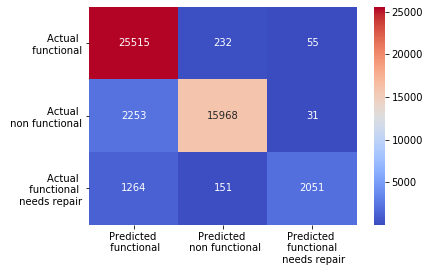

In [291]:
y_train_rf_pred = rf.predict(x_train)

cm_train_rf = confusion_matrix(y_train, y_train_rf_pred,labels=['functional','non functional','functional needs repair'])
cm_train_rf_pd = pd.DataFrame(data=cm_train_rf,columns=['Predicted \n functional','Predicted \n non functional','Predicted \n functional \n needs repair'],index=['Actual \n functional', 'Actual \n non functional', 'Actual \n functional \n needs repair'])
sns.heatmap(cm_train_rf_pd, annot=True, fmt='d', cmap='coolwarm')
plt.show()

Validation set confusion matrix

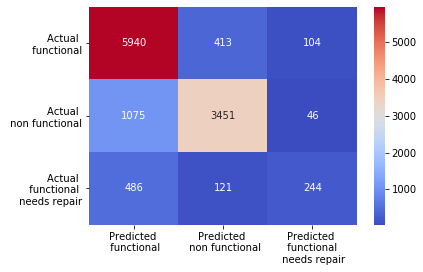

In [292]:
y_val_rf_pred = rf.predict(x_val)

cm_val_rf = confusion_matrix(y_val, y_val_rf_pred,labels=['functional','non functional','functional needs repair'])
cm_val_rf_pd = pd.DataFrame(data=cm_val_rf,columns=['Predicted \n functional','Predicted \n non functional','Predicted \n functional \n needs repair'],index=['Actual \n functional', 'Actual \n non functional', 'Actual \n functional \n needs repair'])
sns.heatmap(cm_val_rf_pd, annot=True, fmt='d', cmap='coolwarm')
plt.show()

Feature importance in the model

In [316]:
model = rf.fit(x_train,y_train.values.ravel())
values = sorted(zip(x_train.columns, model.feature_importances_), key=lambda x: -x[1])
values

[('quantity', 0.16990226708032533),
 ('longitude', 0.11873699525707433),
 ('latitude', 0.1133420103316828),
 ('gps_height', 0.07529083820230012),
 ('waterpoint_type', 0.07173701259781544),
 ('construction_year', 0.06875371495113762),
 ('payment', 0.04961048405602542),
 ('extraction_type_class', 0.04790078338202238),
 ('funder', 0.03073593528530361),
 ('extraction_type', 0.03064363871959832),
 ('source', 0.0267578313226082),
 ('district_code', 0.025616291250413394),
 ('region', 0.02507128456714352),
 ('date_recorded', 0.024552434604962328),
 ('installer', 0.02094377879589857),
 ('management', 0.018404757644189394),
 ('basin', 0.01749878619919049),
 ('scheme_management', 0.014639723430497999),
 ('permit', 0.009113685698184862),
 ('water_quality', 0.008802111878357685),
 ('management_group', 0.008784461011675517),
 ('source_class', 0.00864267455063156),
 ('public_meeting', 0.007716332820744113),
 ('lga', 0.006802166362217078)]

## Modeling using an XGBClassifier

In [321]:
#import xgboost as xgb
#from xgboost import plot_importance

In [322]:
#xgb_model = xgb.XGBClassifier(objective='multi:softprob', n_estimators=200, max_depth=20, random_state=42)
#xgb_model.fit(x_train,y_train.values.ravel())

In [323]:
#print(xgb_model.score(x_train,y_train))
#print(xgb_model.score(x_val,y_val))

In [324]:
#confusion_matrix(y_val,xgb_model.predict(x_val))

In [325]:
#plot_importance(xgb_model)
#plt.show()

## Testing

### Obtain predictions from model on test set

In [232]:
y_test_rf_pred = rf.predict(test_scaled_inputs)

### Create csv file for submission

In [233]:
df_submission = df_test_values[['id']].copy()

In [234]:
df_submission['status_group'] = y_test_rf_pred

In [235]:
df_submission.head()

,id,status_group
0,50785,non functional
1,51630,functional
2,17168,functional
3,45559,non functional
4,49871,functional


In [236]:
df_submission.to_csv('test_predictions.csv', index=False)